In [1]:
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import random

from scipy.signal import convolve2d
from scipy.ndimage import convolve

# from perlin_noise import perlin_noise
# from flood_fill import flood_fill

from utils import generate_grid
from utils import plot_trajectory
from utils import spawn_point

In [2]:
plt.rcParams['figure.figsize'] = (16,12)
np.random.seed(1234)

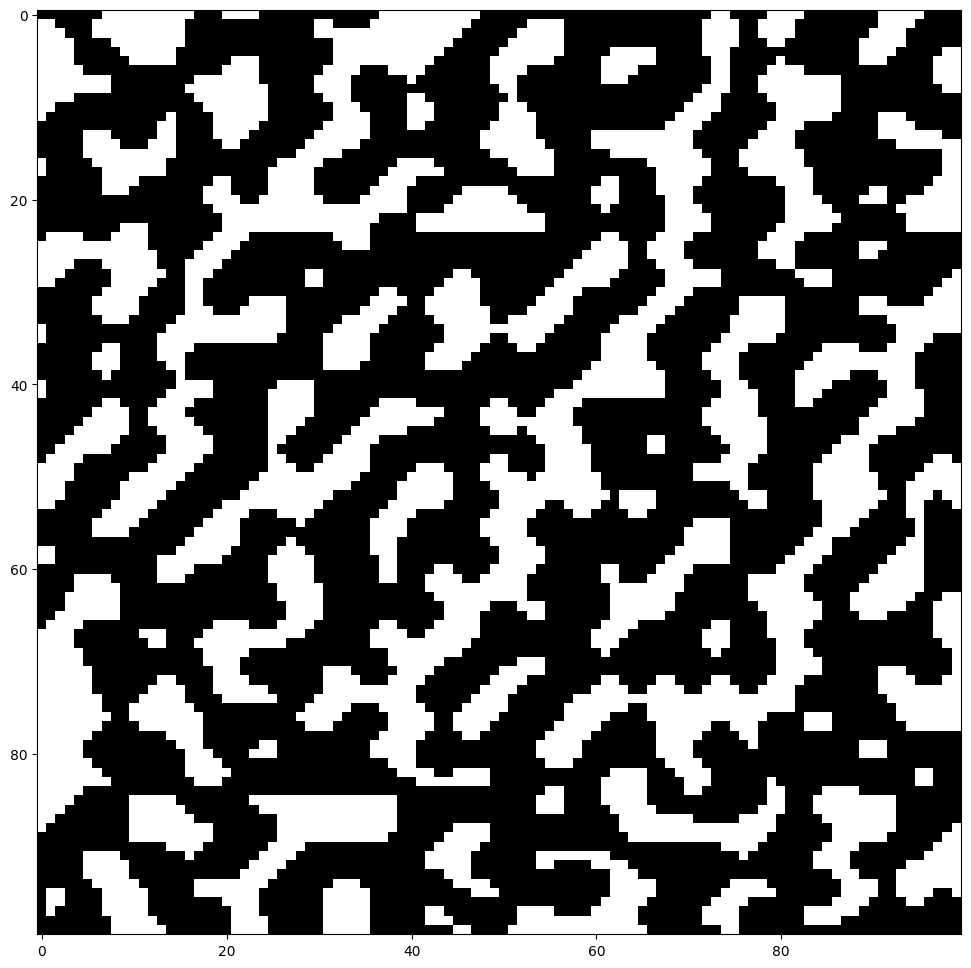

In [3]:
grid = generate_grid(100)
plt.imshow(grid, cmap='grey')
plt.show()

## Movement
 - Randomly move in direction
 - If collision
   - Return to same state
 - Else
   - Keep moving

 % Area covered 0.7210805435863441


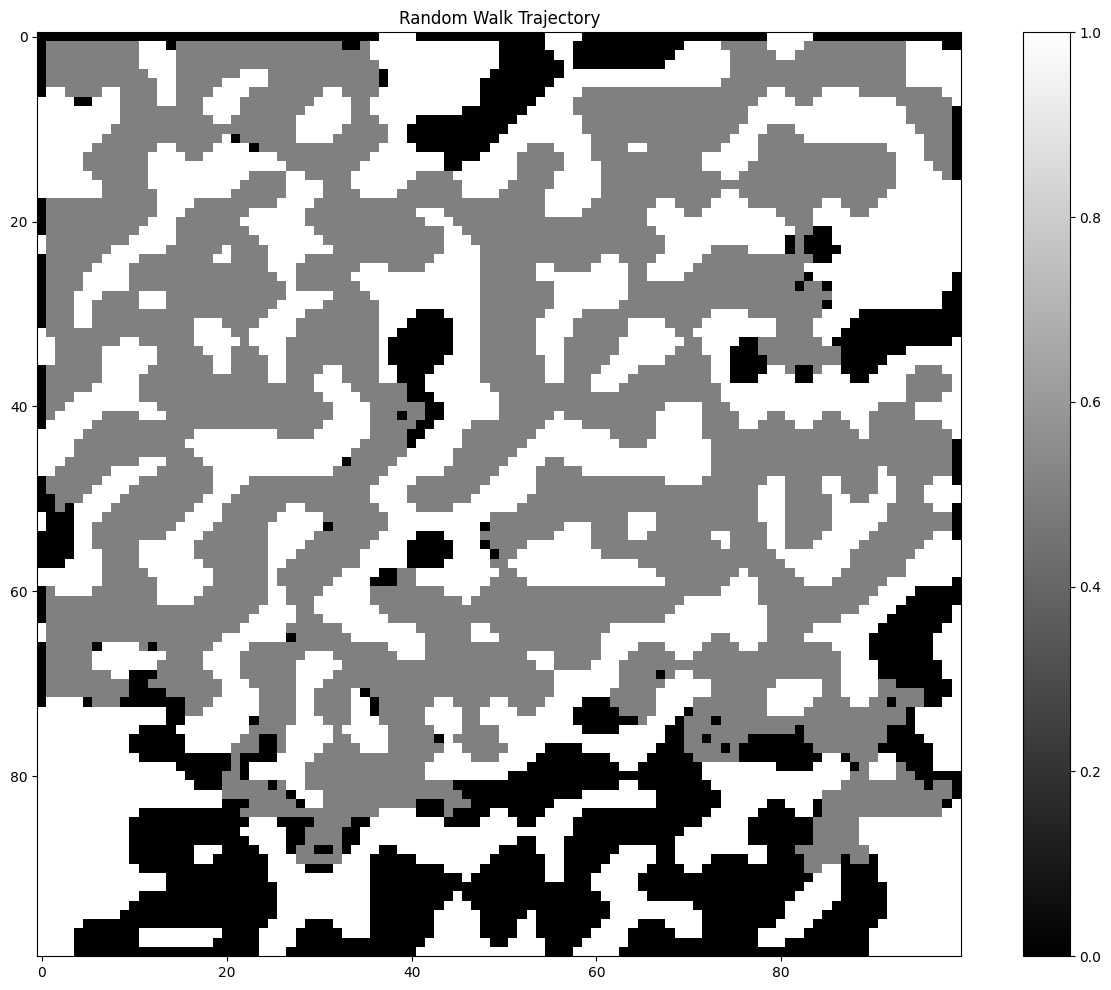

In [4]:
size = 100
grid = generate_grid(size)
height, width = size, size  # Example grid size

# Initialize starting position
current_pos = spawn_point(grid)
x,y = current_pos

# Initialize the trajectory grid and list to track the trajectory
transversed_grid = grid.copy()
trajectory = []
cells_covered = set()

# Number of steps for the random walk
steps = 100000
directions = [(0, 1), (0, -1), (-1, 0), (1, 0)]

for i in range(steps):
    # Possible directions for movement (up, down, left, right)

    # Randomly choose a direction
    move = random.choice(directions)

    # Calculate the new position
    new_pos = current_pos + move

    # Ensure the new position is within the grid boundaries
    if 0 < new_pos[0] < height-1 and 0 < new_pos[1] < width-1 and grid[tuple(new_pos)] != 1:
        current_pos = new_pos
        trajectory.append(tuple(current_pos))
        cells_covered.add(tuple(current_pos))

num_cells_covered = len(cells_covered)
empty_cells = np.count_nonzero(grid==0)
area_covered = num_cells_covered/empty_cells
for point in trajectory:
    transversed_grid[point] = 0.5

print(f' % Area covered {area_covered}')
# Display the trajectory as a heatmap
plt.imshow(transversed_grid, cmap='gray')
plt.title("Random Walk Trajectory")
plt.colorbar()
plt.show()

In [5]:
print(f' Number of empty cells {empty_cells}, number of cells covered = {len(cells_covered)}, length of trajectory = {len(trajectory)}')

 Number of empty cells 6034, number of cells covered = 4351, length of trajectory = 87769


## Visibliity
 - Agent can see 5x5 or 3x3 around them
 - Implement by slicing  grid points
 - Initialize unknow global map
 - Update map by slicing information

(100, 100, 3) (100, 100)


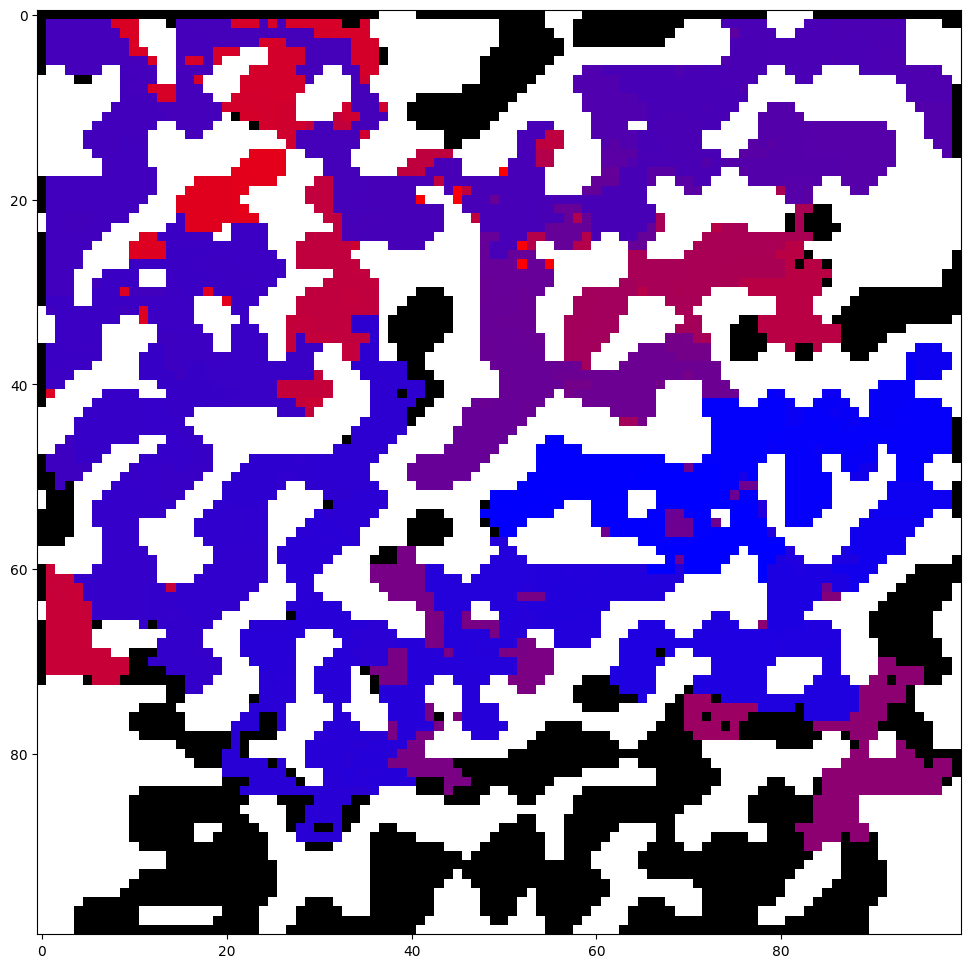

In [6]:
plot_trajectory(grid, trajectory)

In [7]:
# WHEN AT POSITION X,Y
def get_visible(grid, x,y):
    """
    Get the slice of array which is visible to the agent from position x,y
    """
    padding = ((1, 1), (1, 1))
    padded_grid = np.pad(grid, padding, mode='constant', constant_values=-1)
    visible_space = padded_grid[x:x+3, y:y+3]

    return visible_space

## Converting to RL environment
- State = visible patch, current position
- Action = move
- reward = -1
- terminal condition = Whole grid is explored 

In [8]:
class GridEnv():
    def __init__(self, size=100):
        
        self.grid = generate_grid(size)
        self.height, self.width = size, size
        self.actions = {
            "UP" : (0, 1), 
            "DOWN" : (0, -1), 
            "LEFT" : (-1, 0), 
            "RIGHT" : (1, 0),
        }
        self.trajectory = []
        self.agent_start_position = np.array((0,0))
        self.agent_position = self.agent_start_position

    def reset(self):
        self.agent_position = self.agent_start_position
        done = False
        x,y = self.agent_position
        visible_patch = get_visible(self.grid, x,y)
        state = (self.agent_position, visible_patch)
        return state, done
    
    def step(self, action):
        movement = self.actions[action]
        new_position = self.agent_position + movement
        done = False
        # print(self.agent_position,  new_position, self.grid[tuple(new_position)])
        if 0 <= new_position[0] <= self.height-1 and 0 <= new_position[1] <= self.width-1 and self.grid[tuple(new_position)] != 1:
            self.agent_position = new_position
            self.trajectory.append(tuple(current_pos))
            reward = -1
        else:
            done = True
            reward = -100

        x,y = self.agent_position
        visible_patch = get_visible(self.grid, x,y)
        new_state = (self.agent_position, visible_patch)

        return new_state, reward, done

    def sample_action(self):
        return random.choice(list(self.actions.keys()))

    def plot_grid(self):
        plt.imshow(self.grid, cmap='gray')
        plt.show()

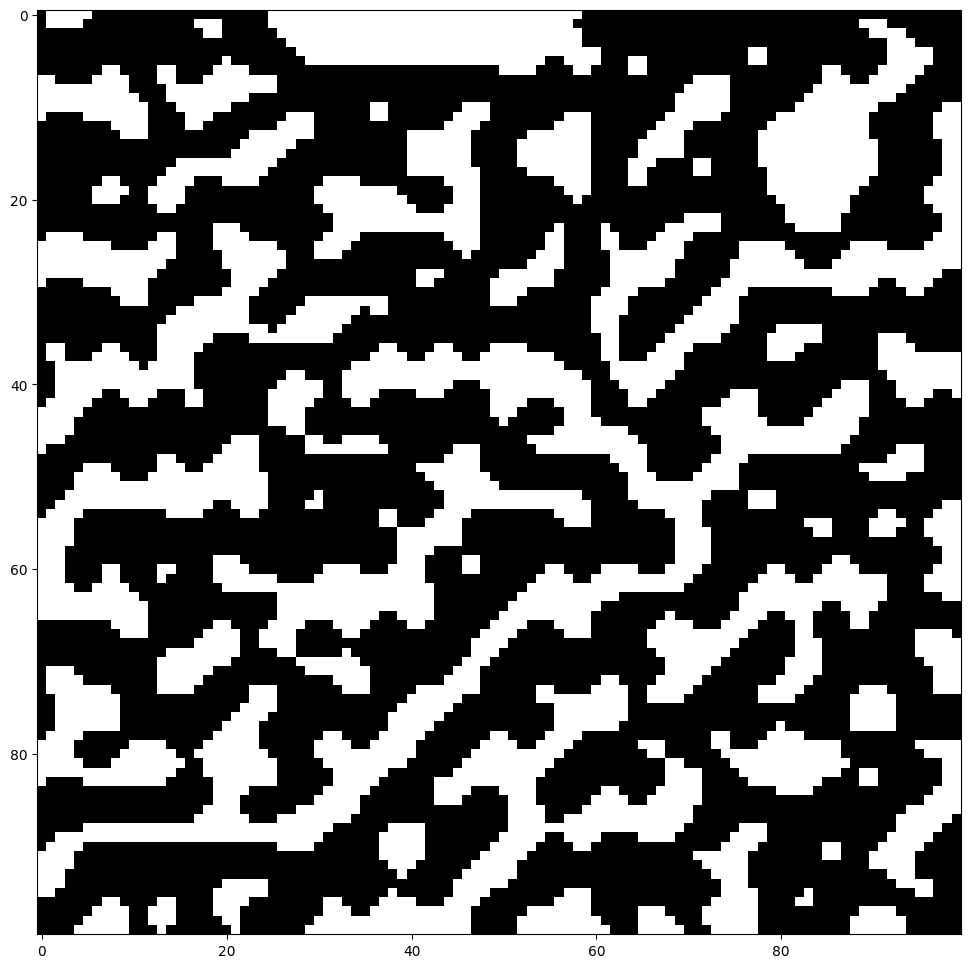

In [9]:
env = GridEnv(size=100)
env.sample_action()
env.plot_grid()

## Agent
- Take random action
- Note trajectory, current position, and visible patch at all times
- Agent can take random action
- Agent needs to add current poision to trajectory
- Agent state -> (4xgrid)
  - 0 for unknown
  - 1 for obstacle
  - 0.5 for explored part,
  - 2 for current position

In [10]:
class Agent():
    def __init__(self, size=100, visible_patch=3):
        self.trajectory = []
        self.position = np.array((0,0))
        self.visible_patch = np.zeros((visible_patch,visible_patch))
        self.grid = np.zeros((size, size))
        self.size = size
    
    def update_state(self, visible_patch, position):
        x,y = position
        visible_patch = (visible_patch + 1) * (0.5)
        for dx in range(-1, 2):  # This will loop through -1, 0, 1
            for dy in range(-1, 2):  # This will loop through -1, 0, 1
                nx, ny = x + dx, y + dy            
                if 0 <= nx < size and 0 <= ny < size:
                    self.grid[nx][ny] = visible_patch[1+dx,1+dy]
        self.trajectory.append(tuple(position))

        # TO ACCOMODATE FOR CURRENT POSITION, CAN ALSO SAVE AS NEXT POSITION
        state_grid = self.grid.copy()
        state_grid[x,y] = 2
        return state_grid

    def show_grid(self):
        plt.imshow(self.grid, cmap='grey')
        plt.show()

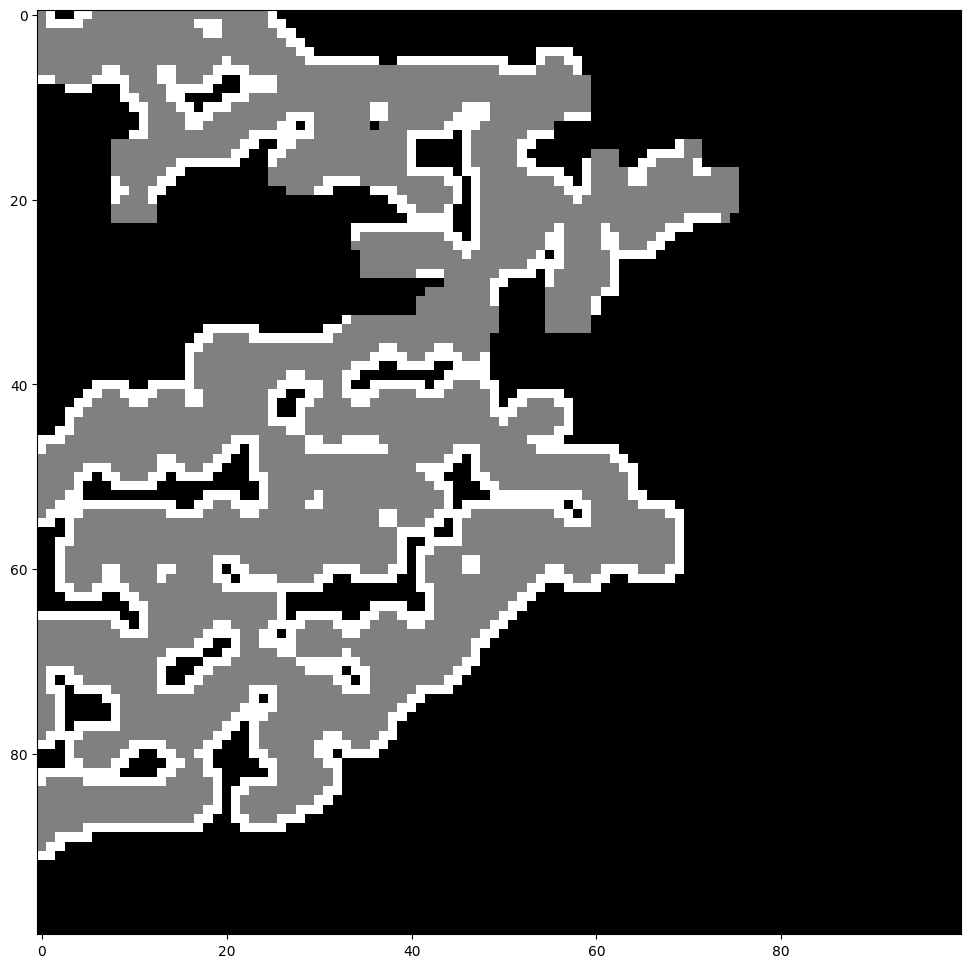

In [11]:
agent = Agent()
env.reset()

for i in range(100000):
    action = env.sample_action()
    new_state, reward, done = env.step(action)

    new_pos, visible_patch = new_state
    agent.update_state(visible_patch, new_pos)
agent.show_grid()

## Deep Q Learning
- Replay Buffer
- Sample actions from env
- Store in buffer of size
- Sample from buffer
- If train_freq
- - Train policy
- If target_freq
- - Train target network

In [12]:
class ReplayBuffer():
    def __init__(self, buffer_size=10_000):
        # STORE S,A,R,S`,D
        self.buffer = []
        self.buffer_size = buffer_size

    def initialize_buffer(self, env, action_model):
        state, done = env.reset()
        state = np.zeros_like(env.grid)
        action_keys = list(env.actions.keys())
        for i in range(self.buffer_size):
            action = env.sample_action()
            # action = agent_model(state)
            next_state, reward, done = env.step(action)
            action_key = action_keys.index(action)
            next_pos, visible_patch = next_state
            next_state = agent.update_state(visible_patch, next_pos)
            replay = (state, action_key, next_state, reward, done)
            self.buffer.append(replay)

            if done:
                state, done = env.reset()
                state = np.zeros_like(env.grid)
            state = next_state    

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def length(self):
        return len(self.buffer)

    def sample_batch(self, batch_size=32):
        batch = []
        idx = random.sample(range(0,self.buffer_size), batch_size)
        for i in idx:
            if i > len(self.buffer):
                print(i, len(self.buffer))
            batch.append(self.buffer[i])
        return batch

    def unwrap_batch(self, batch):
        states = []
        actions = []
        next_states = []
        rewards = []
        dones = []
        
        for item in batch:
            state, action, next_state, reward, done = item
            states.append(state)
            actions.append(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
        return states, actions, rewards, next_states, dones

In [13]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [14]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 21 * 21, 128)  # After 3 pooling layers (100 -> 12)
        self.fc2 = nn.Linear(128, 4)  # Output 4 classes

        self.flattern = nn.Flatten()
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))

        x = self.flattern(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

In [15]:
model = DQN()
grid_tensor = torch.from_numpy(grid).unsqueeze(0).unsqueeze(0)
model(grid_tensor)

tensor([[0.2399, 0.2701, 0.2398, 0.2503]], grad_fn=<SoftmaxBackward0>)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent_model = DQN().to(device)
target_model = DQN().to(device)
target_model =target_model.load_state_dict(state_dict=agent_model.state_dict())

opt_agent = torch.optim.AdamW(agent_model.parameters(), lr=0.0005)


def optimize_agent(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)

    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    next_states = next_states.unsqueeze(dim=1)
    
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)
    print(states.shape, actions.shape, rewards.shape, next_states.shape, dones.shape)
    # Optimize critic loss
    with torch.no_grad():
        q_values = agent_model(next_states)  # Get the next action from the actor for next state
        target_q_values = rewards + gamma * (1 - dones) * target_model(next_states)

    critic_loss = F.mse_loss(q_values, target_q_values)  # Mean Squared Error loss
    opt_agent.zero_grad()
    critic_loss.backward()
    opt_agent.step()

def optimize_target():
    target_model.load_state_dict(state_dict=agent_model.state_dict())

/home/ajax/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [17]:
buffer = ReplayBuffer()
buffer.initialize_buffer(env=env, action_model=agent_model)

In [18]:
def get_action(self, epsilon,state):
    if np.random.random() < epsilon:  # with probability eps, the agent selects a random action
        action = np.random.choice(self.action_space, 1)[0]
        return action
    else:  # with probability 1 - eps, the agent selects a greedy policy
        obs = self._arr_to_tensor(obs).view(1, -1)
        with torch.no_grad():
            q_values = self.behavior_policy_net(obs)
            action = q_values.max(dim=1)[1].item()
        return self.action_space[int(action)]

In [21]:
class DQNAgent():
    def __init__(self, params):
        # Set all params
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.params = params
        self.env = GridEnv()
        self.action_keys = list(self.env.actions.keys())

        self.behavior_net = DQN().to(self.device)
        self.target_net = DQN().to(self.device)
        self.target_net.load_state_dict(state_dict=self.behavior_net.state_dict())
        
        self.buffer = ReplayBuffer()
        self.buffer.initialize_buffer(self.env, self.behavior_net)
        
    def get_action(self, epsilon, state):
        if np.random.random() == epsilon:
            return self.env.sample_action()
        else:
            state = torch.from_numpy(state).to(device)
            state = state.unsqueeze(0).unsqueeze(0)

            with torch.no_grad():
                q_values = self.behavior_net(state)
                action = q_values.argmax(dim=1)[0].item()

            return self.action_keys[int(action)]

    def optimize_agent(self, states, actions, rewards, next_states, dones):
        # Convert to tensor
        states = np.array(states)
        states = torch.tensor(states, dtype=torch.float).to(device)
        
        actions = torch.tensor(actions, dtype=torch.float).to(device)
        actions = actions.unsqueeze(dim=1)
    
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        rewards = rewards.unsqueeze(dim=1)

        next_states = np.array(next_states)
        next_states = torch.tensor(next_states, dtype=torch.float).to(device)
        next_states = next_states.unsqueeze(dim=1)
        
        dones = torch.tensor(dones, dtype=torch.float).to(device)
        dones = dones.unsqueeze(dim=1)
        
        q_values = self.behavior_net(next_states)
        with torch.no_grad():
            target_q_values = rewards + self.params['gamma'] * (1 - dones) * self.target_net(next_states)
    
        critic_loss = F.mse_loss(q_values, target_q_values)
        opt_agent.zero_grad()
        critic_loss.backward()
        opt_agent.step()
    
    def optimize_target(self):
        self.target_net.load_state_dict(state_dict=self.behavior_net.state_dict())
        
    def train(self):

        num_steps=self.params['num_steps']
        epsilon = self.params['epsilon']
        decay = self.params['decay']
        min_epsilon = self.params['min_epsilon']

        # RESET ENV
        state,done = env.reset()
        state = np.zeros_like(env.grid)
        G = 0
        for i in range(num_steps):

            # GENERATE STUFF AND ADD TO BUFFER
            # try:
            action = self.get_action(epsilon, state)
            # except:
                # print(state.shape, done)

            action_key = self.action_keys.index(action)
            
            next_state, reward, done = env.step(action)
            next_pos, visible_patch = next_state
            next_state = agent.update_state(visible_patch, next_pos)
            
            replay_item = (state, action_key, next_state, reward, done)    
            self.buffer.add(replay_item)

            if done:
                state, done = env.reset()
                state = np.zeros_like(env.grid)
                G = 0
            else:
                G += reward
                state = next_state

            epsilon = max(min_epsilon, epsilon*decay)            

            # IF TRAIN FREQ UPDATE AGENT
            if i % self.params['agent_frq'] == 0:
                batch = self.buffer.sample_batch(batch_size=self.params['batch_size'])
                states, actions, rewards, next_states, dones = self.buffer.unwrap_batch(batch)
                self.optimize_agent(states, actions, rewards, next_states, dones)

            # IF TARGET_FREQ UPATE TARGET            
            if i % self.params['target_frq'] == 0:
                self.optimize_target()

            if i%1_000 == 0:
                print(f' step = {i}')

In [22]:
train_parameters = {
    'observation_dim': 2,
    'action_dim': 4,
    'gamma': 0.99,

    'epsilon':1,
    'decay':0.99,
    'min_epsilon':0.01,
    
    'total_training_time_step': 200_000,

    'epsilon_start_value': 1.0,
    'epsilon_end_value': 0.01,
    'epsilon_duration': 250_000,

    'replay_buffer_size': 50_000,
    'start_training_step': 2000,
    'agent_frq': 4,
    'target_frq': 1000,

    'batch_size': 64,
    'learning_rate': 1e-3,
    'num_steps': 10_000,
    'model_name': "four_room.pt"
}
dqn_agent = DQNAgent(train_parameters)

dqn_agent.train()

/tmp/ipykernel_153261/80524201.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float).to(device)


 step = 0
 step = 1000
 step = 2000
 step = 3000
 step = 4000
 step = 5000
 step = 6000
 step = 7000
 step = 8000
 step = 9000


In [23]:
agent_model = dqn_agent.behavior_net

In [ ]:
agent = Agent()
state, done = env.reset()

for i in range(100000):
    action = env.sample_action()
    new_state, reward, done = env.step(action)

    new_pos, visible_patch = new_state
    agent.update_state(visible_patch, new_pos)
agent.show_grid()